# DEEP LEARNING - PRÁCTICA FINAL

### Sergio del Castillo Baranda

## Uso de la transferencia de conocimiento para la clasificación de imágenes

Para la elaboración de esta práctica se utilizarán herramientas que facilitan el trabajo de modelado, creación y entrenamiento de redes neuronales para finalmente realizar la clasificación.

#### Herramientas:
 - Tensorflow: Software que nos permite generar modelos con una gran capacidad de personalización.
 - Keras: API de alto nivel que facilita el trabajo con tensorflow

#### Arquitectura:
 - Conjunto de capas densas que formarán nuestra red neuronal
 - VGG16: Red convolucional preentrenada que transformaremos para utilizarla con nuestros datos

#### Datos:
Para el entrenamiento de estas redes utilizaremos un dataset compuesto por imágenes de diferentes tipos de osos. Con este conjunto de imágenes se busca aportar la información suficiente a la red neuronal para que aprenda los tipos de osos que buscamos clasificar para que posteriormente, si le presentamos una nueva imágen con un nuevo oso, pueda determinar a que grupo pertecenecería dadas las similitudes encontradas con las imágenes utilizadas en el entrenamiento.



## Configuración del dispositivo

## Los tipos de osos los vamos a clasificar en (3) clases:

### **Black**

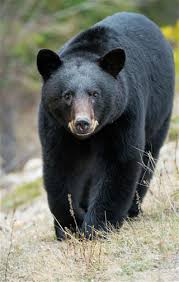

### **Grizzly**

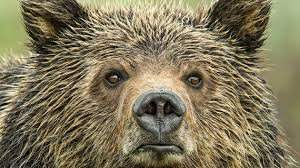

### **Teddys**

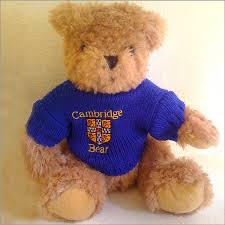

In [1]:
import os
import tarfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from random import randint
from IPython.display import display, Markdown, Image

# Configuración del nivel de errores que mostraremos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

# Uso de la GPU para el entrenamiento de los modelos
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.clear_session()  # Limpieza de la sesión

bear_tar = os.path.join(os.getcwd(), 'osos.tar')
test_tar = os.path.join(os.getcwd(), 'test.tar')

for tar_file in [bear_tar, test_tar]:
    tarf = tarfile.open(tar_file)
    tarf.extractall()

# Ruta con los osos
train_path = os.path.join(os.getcwd(), 'osos')
test_path = os.path.join(os.getcwd(), 'test')

NUMCLASSES = len(os.listdir(train_path))

display(Markdown("## Los tipos de osos los vamos a clasificar en ({}) clases:".format(NUMCLASSES)))
for root, dirs, files in os.walk(train_path, topdown=False):
    if files:
        display(Markdown("### **{}**".format(os.path.basename(root).capitalize())))
        display(Image(filename=os.path.join(root,files[randint(0, len(files))])))

## Arquitectura del modelo

Como modelo base para adaptarlo a la clasificación de osos, se utilizará VGG16 que es una red neuronal convolucional preentrenada con unos 15 millones de imágenes de alta calidad.

- Esta formada por 16 capas.
- Utiliza imágenes de 224x224
- Tiene 1000 canales, uno por clase que es capaz de clasificar

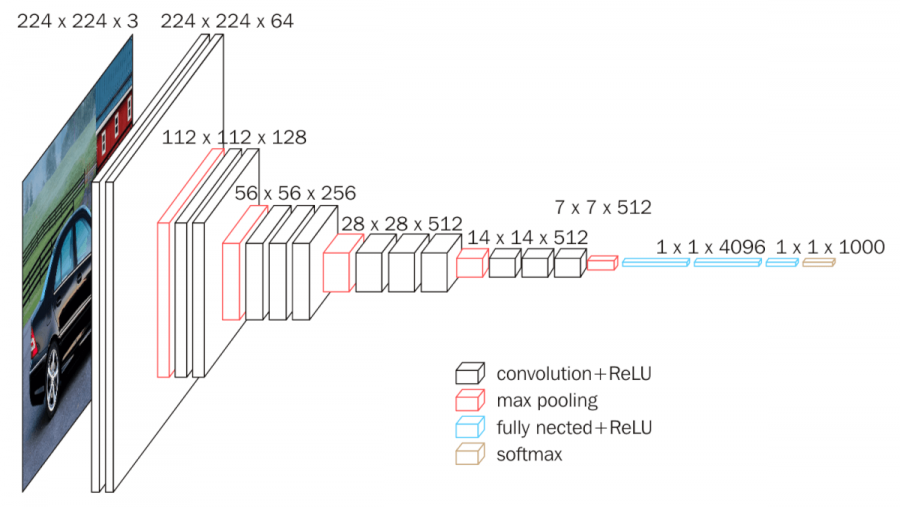

Lo que vamos a realizar con este modelo va a ser quitarle la última capa para adaptarla a nuestra clasificación. Para ello vamos a meter unas capas para adptar el modelo para que la salida se ajuste a nuestra clasificación:
 - Capa preentrenada por VGG16 como input GlobalAveragePooling2D
 - Una capa densa con RELU como activador con una salida de 512 unidades
 - Una capa densa de salida con softmax como activador y una salida ajustada al total de clases disponibles

In [2]:
import pandas as pd
import numpy as np
import keras

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet, VGG16, VGG19, Xception  # Modelos probados

base_model=VGG16(weights='imagenet',include_top=False) 
base_model.trainable=False 

x=base_model.output  # Tomamos la salida del modelo que es la que vamos a adaptar
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(NUMCLASSES, activation='softmax')(x)  # Capa final con NUMCLASES como número de elementos de salida

Using TensorFlow backend.


Ahora generamos el modelo al cual le pasamos, como input, la base del modelo escogido (VGG16) y como output la capa de salida que acabamos de generar.

In [3]:
from keras.models import Model

model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [4]:
print("Nuestro sistema tiene ahora {} capas".format(len(model.layers)))

Nuestro sistema tiene ahora 22 capas


## Entrenamiento del modelo

De las capas obtenidas tenemos las que corresponden al modelo preentrenado y las que acabamos de generar, establecemos las últimas como entrenables, el resto ya las hemos obtenido preentrenadas.

In [5]:
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

Generamos un switcher para que podamos utilizar el preprocesado correspondiente al modelo empleado

In [6]:
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from keras.applications.xception import preprocess_input as preprocess_xception

switcher = {
    'vgg16': preprocess_vgg16,
    'vgg19': preprocess_vgg19,
    'xception': preprocess_xception,
    'mobilenet_1.00_224': preprocess_mobilenet,
}

input_shape = (224,224)

# Modificamos en tamaño para los casos en los que se utilice un modelo basado en xception
if base_model.name == 'xception':
    input_shape = (299,299)

A continuación vamos a generar el conjunto de datos para meterlos en el modelo con la función ImageDataGenerator. Para ello incluimos unos cuantos parámetros que nos permiten obtener variaciones a partir de las imágenes incluidas en el dataset.

In [7]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator(preprocessing_function=switcher.get(base_model.name, 'Error'),
                                 rotation_range=20,
                                 horizontal_flip=True) 

train_generator=train_datagen.flow_from_directory(train_path, 
                                                  target_size=input_shape,
                                                  # default parameters
                                                  color_mode='rgb',
                                                  batch_size=2, # Reducimos el número de lotes que se iterarán en el entrenamiento dado que tenemos pocos datos
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 240 images belonging to 3 classes.


A continuación compilamos el modelo. Para ello utilizamos el optimizador Adam para obtener el mejor resultado en el descenso del gradiente. Como función de coste utilizamos categorical crossentropy, dado que es muy útil en nuestro caso ya que ajusta los resultados posibles a una única categoría. Como métrica se utilizará la precisión.

In [8]:
from keras.optimizers import Adam
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=10)

Epoch 1/10
120/120 [==============================] - 4s 33ms/step - loss: 2.0270 - accuracy: 0.8167
Epoch 2/10
120/120 [==============================] - 3s 22ms/step - loss: 0.3944 - accuracy: 0.9625
Epoch 3/10
120/120 [==============================] - 3s 22ms/step - loss: 0.1338 - accuracy: 0.9792
Epoch 4/10
120/120 [==============================] - 3s 22ms/step - loss: 6.7689e-04 - accuracy: 1.0000
Epoch 5/10
120/120 [==============================] - 3s 23ms/step - loss: 1.8102e-04 - accuracy: 1.0000
Epoch 6/10
120/120 [==============================] - 3s 23ms/step - loss: 2.5186e-04 - accuracy: 1.0000
Epoch 7/10
120/120 [==============================] - 3s 22ms/step - loss: 6.6989e-04 - accuracy: 1.0000
Epoch 8/10
120/120 [==============================] - 3s 22ms/step - loss: 7.8364e-04 - accuracy: 1.0000
Epoch 9/10
120/120 [==============================] - 3s 22ms/step - loss: 5.6026e-04 - accuracy: 1.0000
Epoch 10/10
120/120 [==============================] - 3s 22ms/step

Ahora ya tenemos entrenado el modelo, a continuación lo probaremos para comprobar si obtiene bien los resultados pasándole imágenes.

# Predicción sobre los datos existentes:

## Categoría **Black**:

El siguiente oso es de la categoría **black** al 100.00%

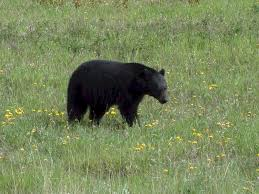

El siguiente oso es de la categoría **black** al 100.00%

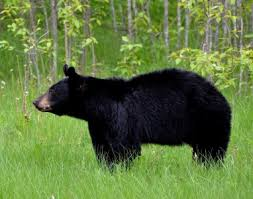

El siguiente oso es de la categoría **black** al 99.60%

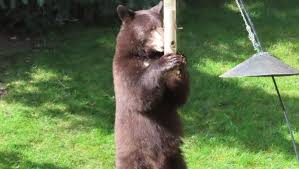

El siguiente oso es de la categoría **black** al 100.00%

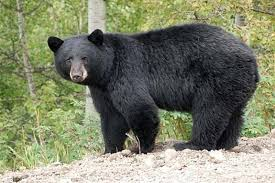

----

## Categoría **Grizzly**:

El siguiente oso es de la categoría **grizzly** al 100.00%

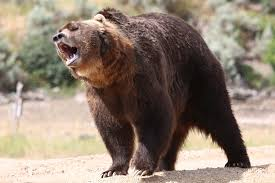

El siguiente oso es de la categoría **grizzly** al 100.00%

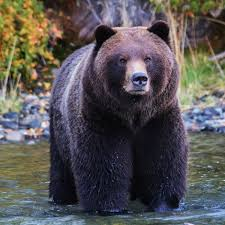

El siguiente oso es de la categoría **grizzly** al 100.00%

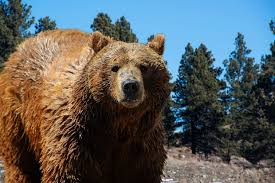

El siguiente oso es de la categoría **grizzly** al 100.00%

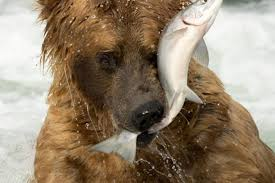

----

## Categoría **Teddys**:

El siguiente oso es de la categoría **teddys** al 100.00%

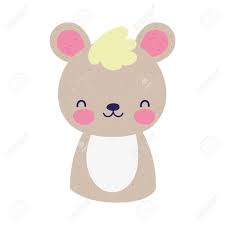

El siguiente oso es de la categoría **teddys** al 100.00%

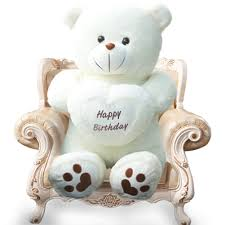

El siguiente oso es de la categoría **teddys** al 100.00%

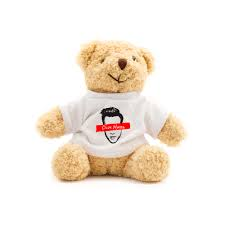

El siguiente oso es de la categoría **teddys** al 100.00%

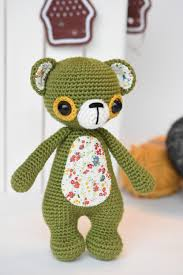

----

# Predicción sobre el dataset descargado:

El siguiente oso es de la categoría **grizzly** al 100.00%

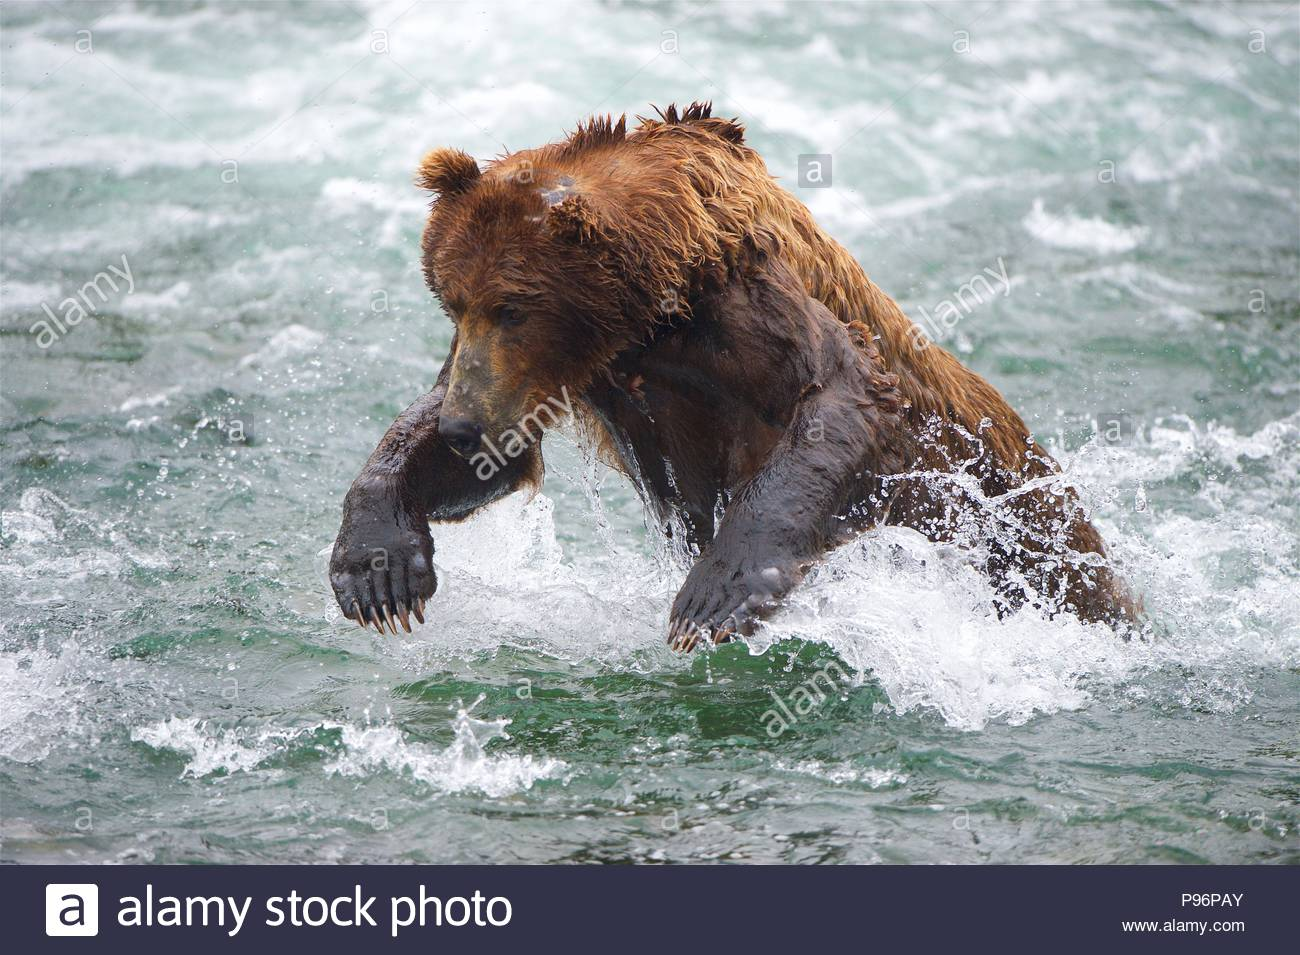

El siguiente oso es de la categoría **teddys** al 100.00%

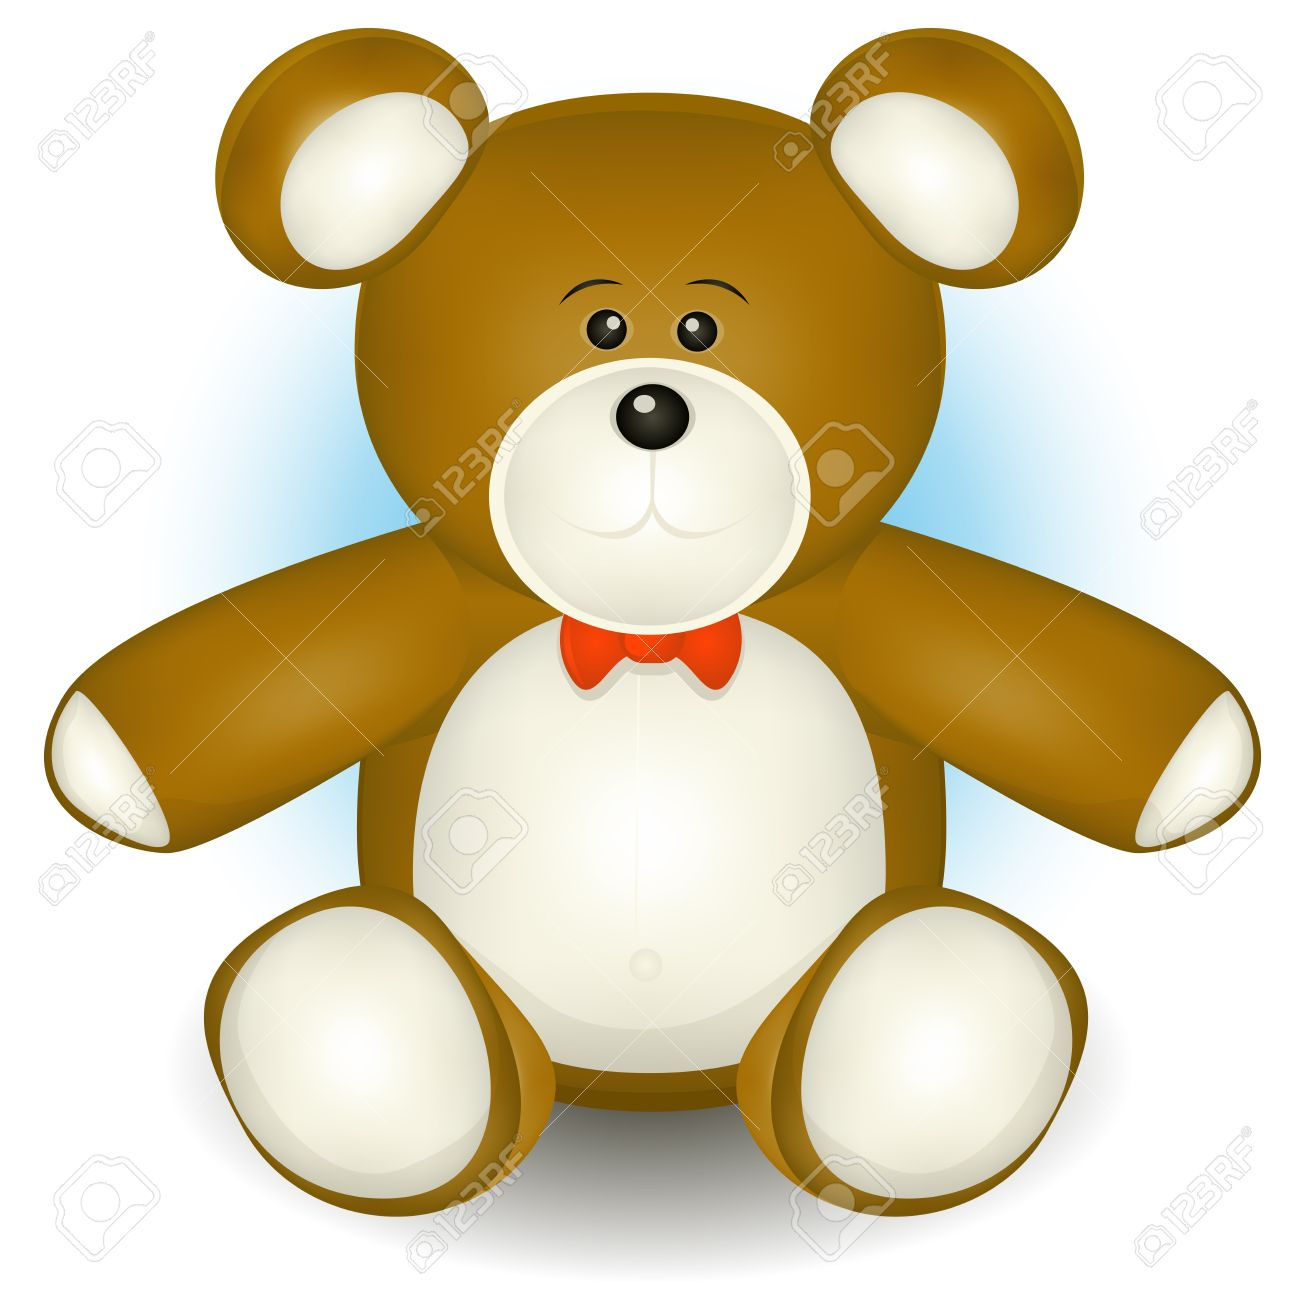

El siguiente oso es de la categoría **teddys** al 100.00%

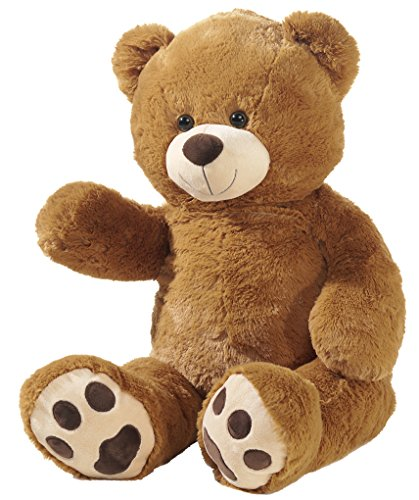

El siguiente oso es de la categoría **grizzly** al 100.00%

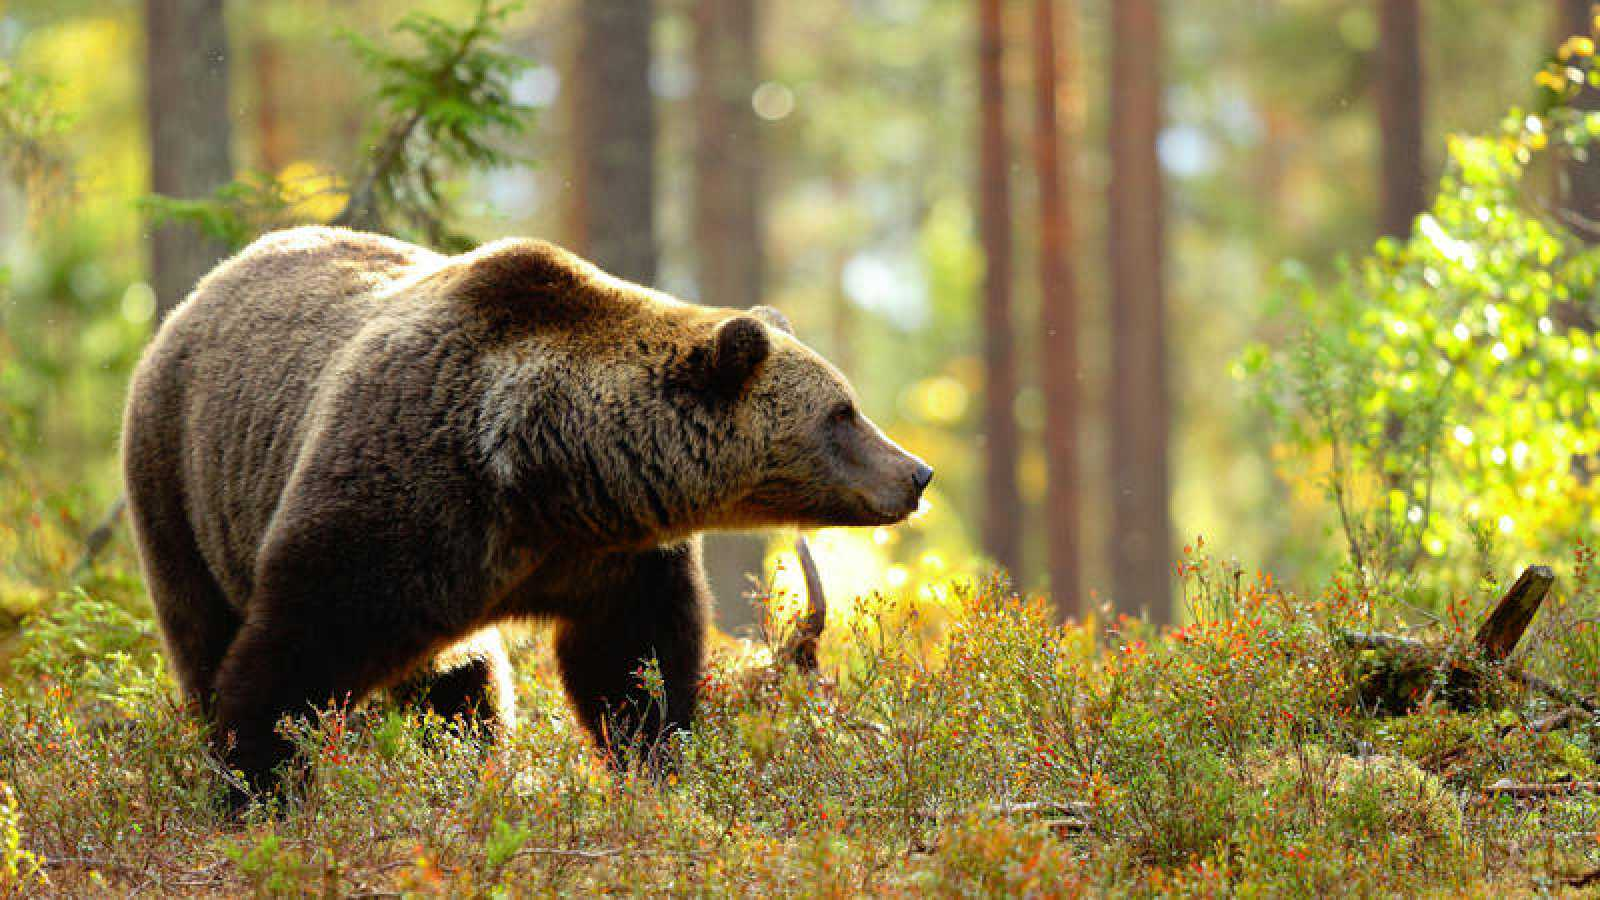

El siguiente oso es de la categoría **grizzly** al 100.00%

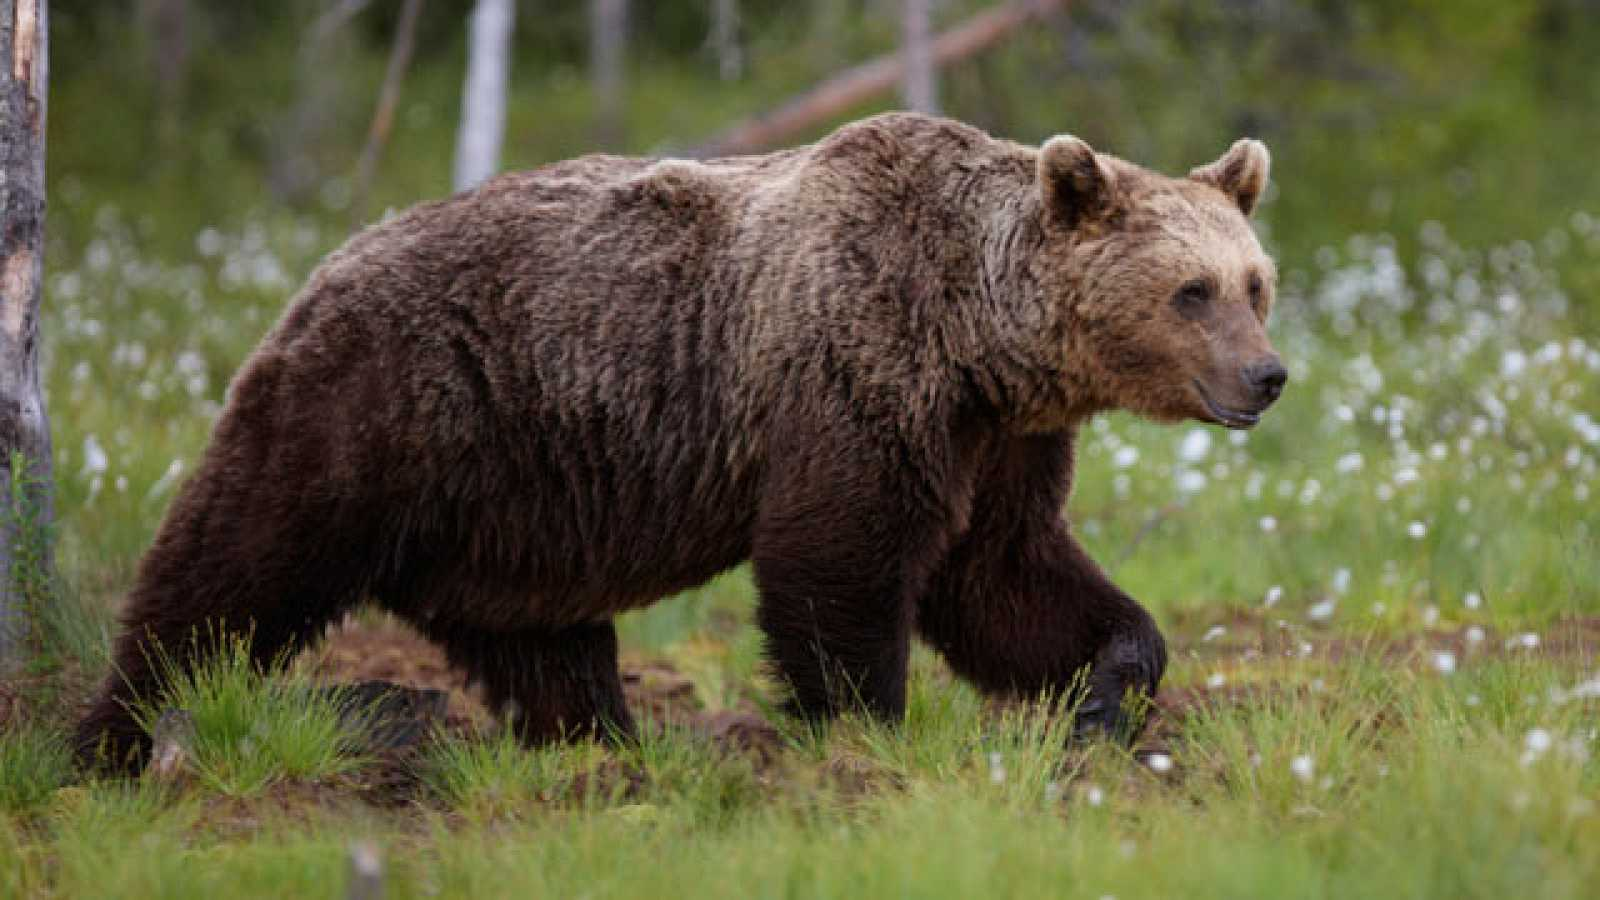

El siguiente oso es de la categoría **teddys** al 100.00%

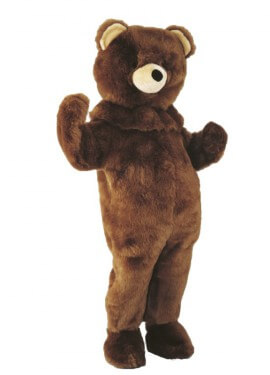

El siguiente oso es de la categoría **teddys** al 100.00%

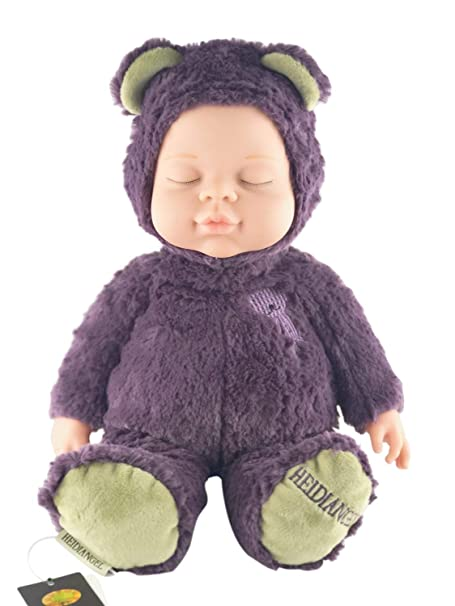

El siguiente oso es de la categoría **grizzly** al 68.14%

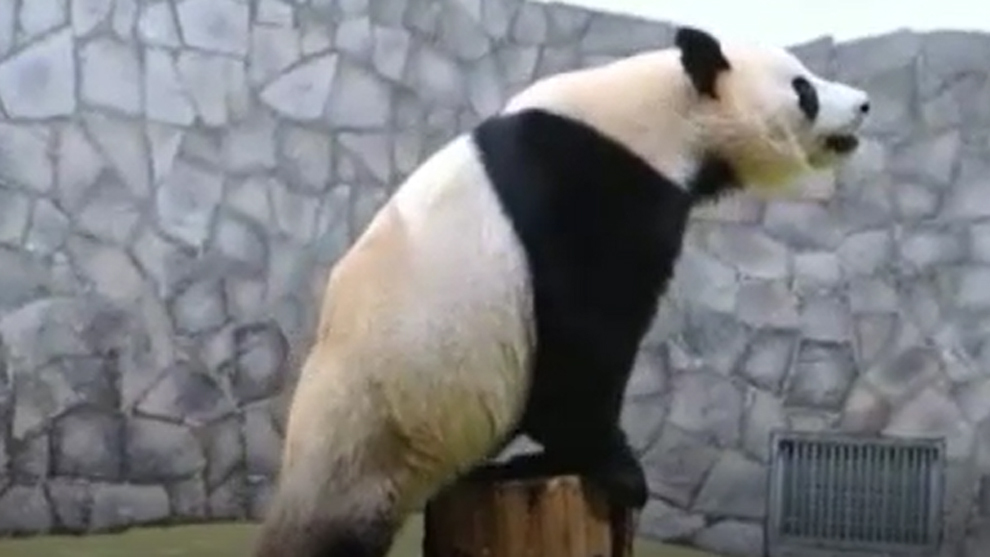

El siguiente oso es de la categoría **grizzly** al 97.44%

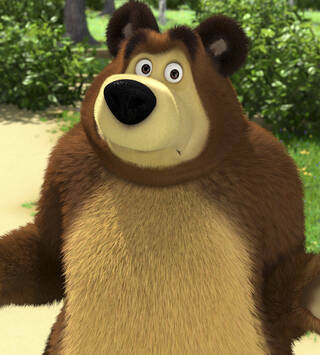

El siguiente oso es de la categoría **grizzly** al 100.00%

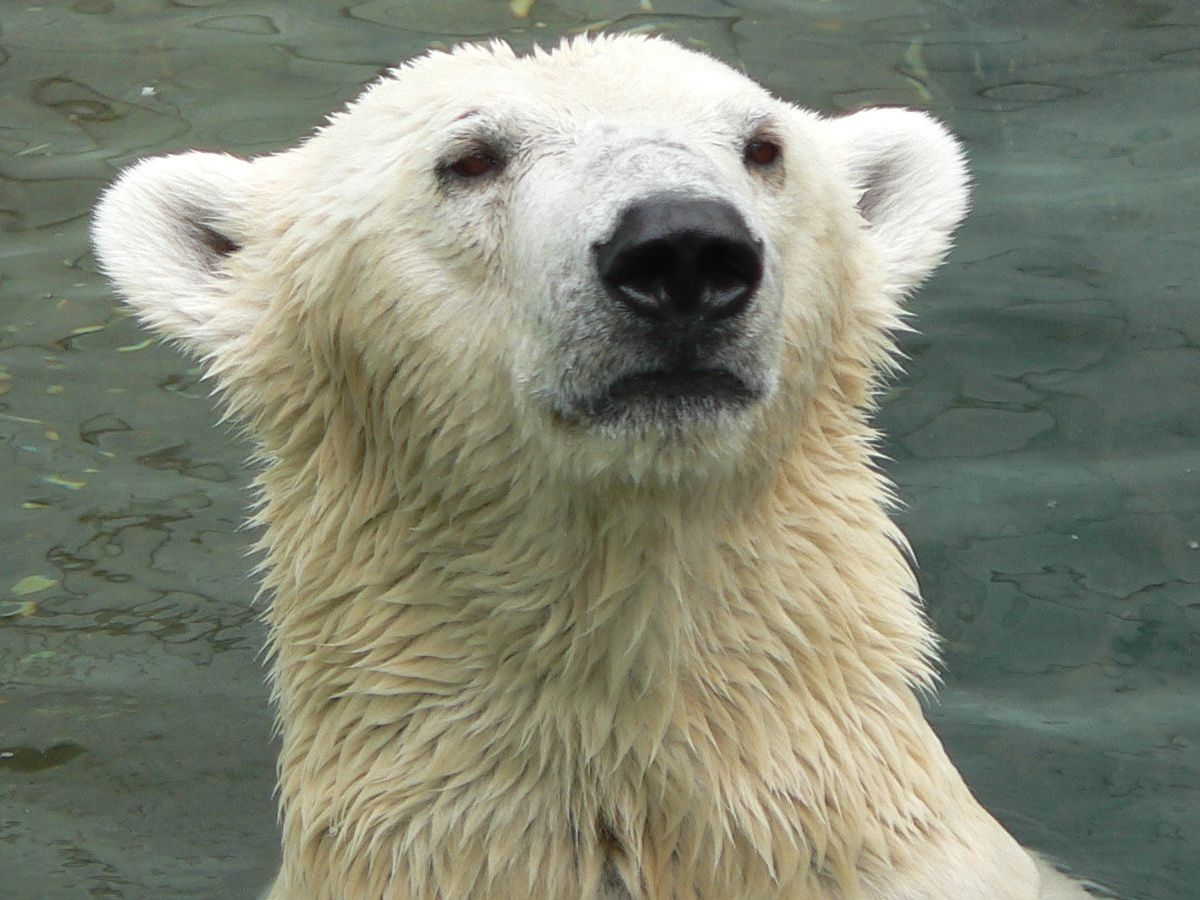

El siguiente oso es de la categoría **grizzly** al 100.00%

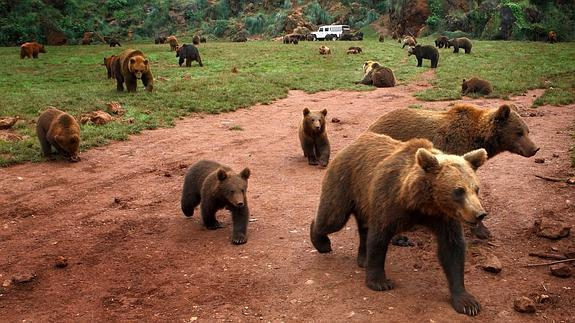

El siguiente oso es de la categoría **grizzly** al 100.00%

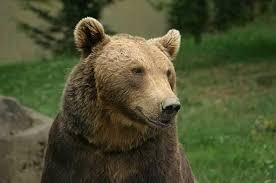

El siguiente oso es de la categoría **teddys** al 100.00%

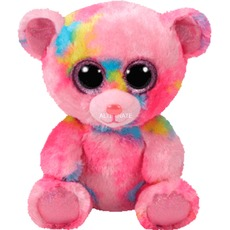

El siguiente oso es de la categoría **teddys** al 100.00%

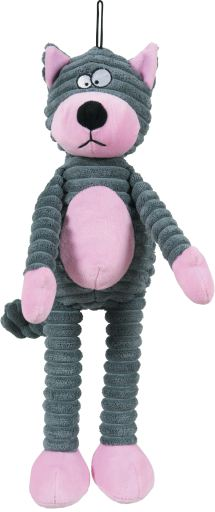

----

In [9]:
from numpy import expand_dims
import matplotlib.pyplot as plt

class_dict = {v:k for k, v in train_generator.class_indices.items()}

def predict_image(path):
    img = image.load_img(path)
    img = img.resize(input_shape)
    data = expand_dims(image.img_to_array(img), 0)
    data = switcher[base_model.name](data)
    preds = model.predict(data)
    pred = np.argmax(preds)
    prediction = class_dict[pred]
    percentage = preds[0][pred]
    return prediction, percentage

display(Markdown("# Predicción sobre los datos existentes:"))
for root, dirs, files in os.walk(train_path, topdown=False):
    if files:   
        display(Markdown("## Categoría **{}**:".format(os.path.basename(root).capitalize())))    
        for i in range(1,5):
            bear_image_path = os.path.join(root,files[i])
            res, p = predict_image(bear_image_path)
            display(Markdown("El siguiente oso es de la categoría **{}** al {:0.2f}%".format(res, p*100)))
            display(Image(filename=bear_image_path))
        display(Markdown("----")) 

display(Markdown("# Predicción sobre el dataset descargado:"))
for root, dirs, files in os.walk(test_path, topdown=False):
        for file in files:
            bear_image_path = os.path.join(root,file)
            res, p = predict_image(bear_image_path)
            display(Markdown("El siguiente oso es de la categoría **{}** al {:0.2f}%".format(res, p*100)))
            display(Image(filename=bear_image_path, width=input_shape[0], height=input_shape[1]))
        display(Markdown("----")) 
        